In [1]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
import random

def gen_data(k=3, dim=2, points_per_cluster=200, lim=[-20, 20]):
    '''
    Generates data from a random mixture of Gaussians in a given range. Will also
    plot the points in case of 2D. 
    
    input:
    - k: Number of Gaussian clusters
    - dim: Dimension of generated points
    - points_per_cluster: Number of points to be generated for each cluster
    - lim: Range of mean values
    
    output:
    - X: Generated points (points_per_cluster*k, dim)
    '''
    x = []
    # Randomly generate means for each cluster in the specified range
    mean = np.random.rand(k, dim)*(lim[1]-lim[0]) + lim[0]
    
    for i in range(k):
        # Generate a random covariance matrix
        cov = np.random.rand(dim, dim) * 0.5  # Random covariance scaled
        cov = np.dot(cov, cov.T)  # Make it symmetric positive-definite
        
        # Generate points from a multivariate normal distribution
        _x = np.random.multivariate_normal(mean[i], cov, points_per_cluster)
        x += list(_x)
    
    x = np.array(x)

    if(dim == 2):
        fig = plt.figure()
        ax = fig.gca()
        ax.scatter(x[:,0], x[:,1], s=3, alpha=0.4)
        ax.autoscale(enable=True)
        plt.show()
    
    return x

In [14]:
class GaussianMixtureModel:
    def __init__(self, k, dim, init_mu=None, init_sigma=None, init_pi=None, colors=None):
        '''
        Define a model with known number of clusters and dimensions.
        
        input:
        - k: Number of Gaussian clusters
        - dim: Dimension
        - init_mu: initial value of mean of clusters (k, dim) 
        (default) random from uniform[-10, 10]
        - init_sigma: initial value of covariance matrix of clusters (k, dim, dim)
        (default) Identity matrix for each cluster
        - init_pi: initial value of cluster weights (k,)
        (default) equal value to all cluster i.e. 1/k
        - colors: Color value for plotting each cluster (k, 3)
        (default) random from uniform[0, 1]
        '''
        self.k = k
        self.dim = dim
        
        if(init_mu is None):
            # Random initialization of means in the range [-10, 10]
            init_mu = np.random.rand(k, dim) * 20 - 10
        self.mu = init_mu
        
        if(init_sigma is None):
            # Default covariance is Identity matrix for each cluster
            init_sigma = np.zeros((k, dim, dim))
            for i in range(k):
                init_sigma[i] = np.eye(dim)
        self.sigma = init_sigma
        
        if(init_pi is None):
            # Equal weights for each cluster by default
            init_pi = np.ones(self.k) / self.k
        self.pi = init_pi
        
        if(colors is None):
            # Random colors for plotting
            colors = np.random.rand(k, 3)
        self.colors = colors

    def e_step(self, data):
        '''
        E-step of EM algorithm.
        '''
        # Initialize responsibilities matrix (z)
        self.z = np.zeros((data.shape[0], self.k))
        
        # Calculate responsibilities for each data point
        for i in range(self.k):
            self.z[:, i] = self.pi[i] * multivariate_normal.pdf(data, mean=self.mu[i], cov=self.sigma[i])
        self.z /= self.z.sum(axis=1, keepdims=True)

    def m_step(self, data):
        '''
        M-step of EM algorithm.
        '''
        sum_z = self.z.sum(axis=0)
        
        # Update cluster weights (pi)
        self.pi = sum_z / data.shape[0]
        
        # Update means (mu)
        self.mu = np.matmul(self.z.T, data)
        self.mu /= sum_z[:, None]
        
        # Update covariances (sigma)
        for i in range(self.k):
            j = np.expand_dims(data, axis=1) - self.mu[i]
            s = np.matmul(j.transpose([0, 2, 1]), j)
            self.sigma[i] = np.matmul(s.transpose(1, 2, 0), self.z[:, i])
            self.sigma[i] /= sum_z[i]

    def fit(self, data, max_iter=100):
        '''
        Fit the Gaussian Mixture Model using the EM algorithm.
        '''
        for _ in range(max_iter):
            self.e_step(data)
            self.m_step(data)

    def predict(self, data):
        '''
        Predict the cluster assignments for the given data.
        '''
        z = np.zeros((data.shape[0], self.k))
        for i in range(self.k):
            z[:, i] = self.pi[i] * multivariate_normal.pdf(data, mean=self.mu[i], cov=self.sigma[i])
        z /= z.sum(axis=1, keepdims=True)
        return np.argmax(z, axis=1)

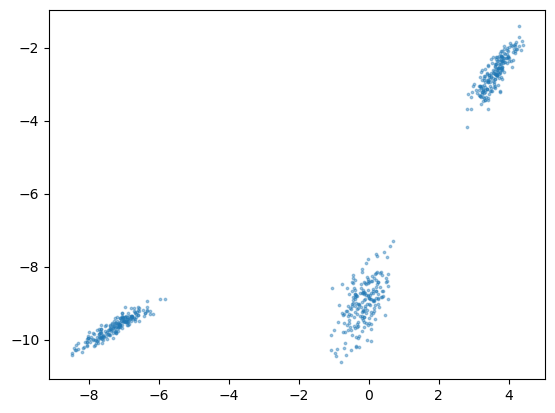

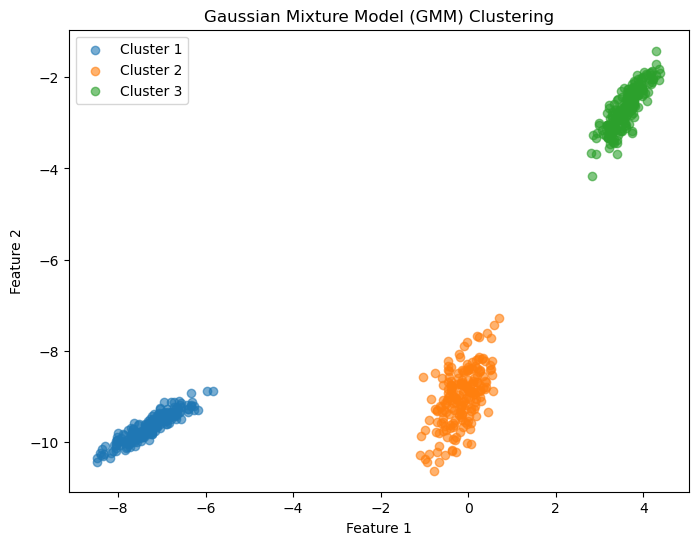

In [15]:
# Generate synthetic data from a mixture of Gaussians
data = gen_data(k=3, dim=2, points_per_cluster=200, lim=[-10, 10])

# Define and initialize the GMM model
gmm = GaussianMixtureModel(k=3, dim=2)

# Fit the GMM model to the data
gmm.fit(data, max_iter=100)

# Predict the cluster assignments for the data
predictions = gmm.predict(data)

# Visualize the clustering results
plt.figure(figsize=(8, 6))
for i in range(3):
    cluster_data = data[predictions == i]
    plt.scatter(cluster_data[:, 0], cluster_data[:, 1], label=f'Cluster {i+1}', alpha=0.6)
plt.title("Gaussian Mixture Model (GMM) Clustering")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend()
plt.show()